In [1]:
from hypecommons import *
from hypecommons import plot as hyplot

from datetime import datetime, timedelta

import numpy as np

SYMBOL = 'BNBBUSD'
FREQ = 1

def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

def normalise(df_orig):
    df = df_orig.copy()
    
    fields = list(df)
    
    for field in fields:
        if field in ['volume', 'trades']:
            for ma in [1, 3, 9]:
                df[f"{field}_pm_ma{ma}"] = df[field].rolling(window=ma).mean() / FREQ
        else:
            if field != 'close':
                df[f"{field}_norm"] = df[field] / df['close']

        if field != 'close':
            df.drop(field, axis=1, inplace=True)
    
    for x in [50, 200]:
        df[f"close_ma{x}_norm"] = df['close'].rolling(window=x).mean() / df['close']
    
    for x in [12, 26]:
        df[f"close_ema{x}_norm"] = ema(df['close'], x) / df['close']
    
#     df.drop('close', axis=1, inplace=True)
    return df

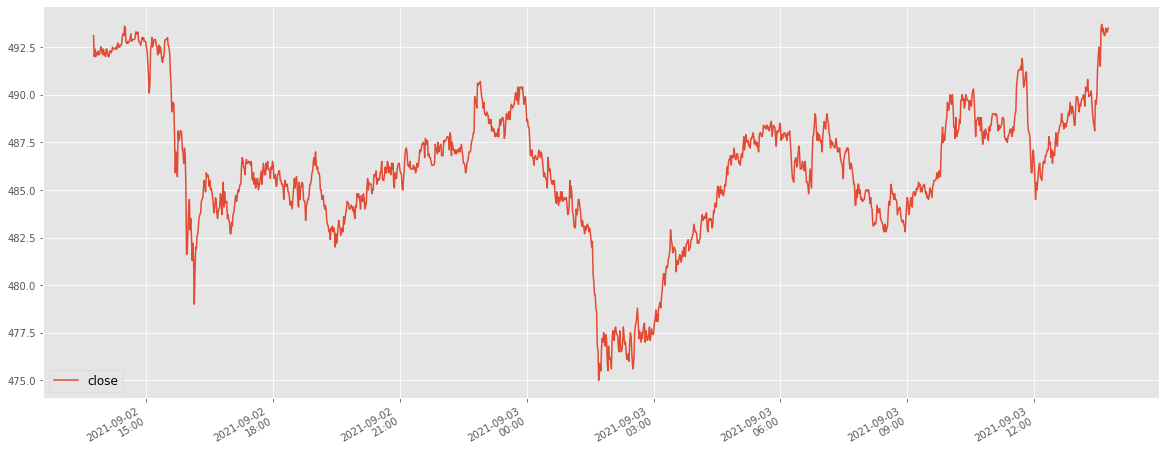

Past BUY signals


,close,close_ema26_norm,close_ma200_norm,ema26_signal,ma200_signal,buy_signal


Latest 10 datapoints


,close,close_ema26_norm,close_ma200_norm,ema26_signal,ma200_signal,buy_signal
2021-09-03 13:36:00,493.700000,0.993978,0.989904,97.9%,93.4%,False
2021-09-03 13:37:00,493.300000,0.995171,0.990743,98.0%,93.5%,False
2021-09-03 13:38:00,493.500000,0.995155,0.990377,98.0%,93.4%,False
2021-09-03 13:39:00,493.200000,0.996074,0.991015,98.1%,93.5%,False
2021-09-03 13:40:00,493.100000,0.996552,0.991249,98.2%,93.5%,False
2021-09-03 13:41:00,493.200000,0.996621,0.991088,98.2%,93.5%,False
2021-09-03 13:42:00,493.500000,0.996310,0.990526,98.2%,93.4%,False
2021-09-03 13:43:00,493.300000,0.996957,0.990961,98.2%,93.5%,False
2021-09-03 13:44:00,493.300000,0.997183,0.990995,98.2%,93.5%,False
2021-09-03 13:45:00,493.500000,0.997017,0.990632,98.2%,93.5%,False


Suggestion: IDLE


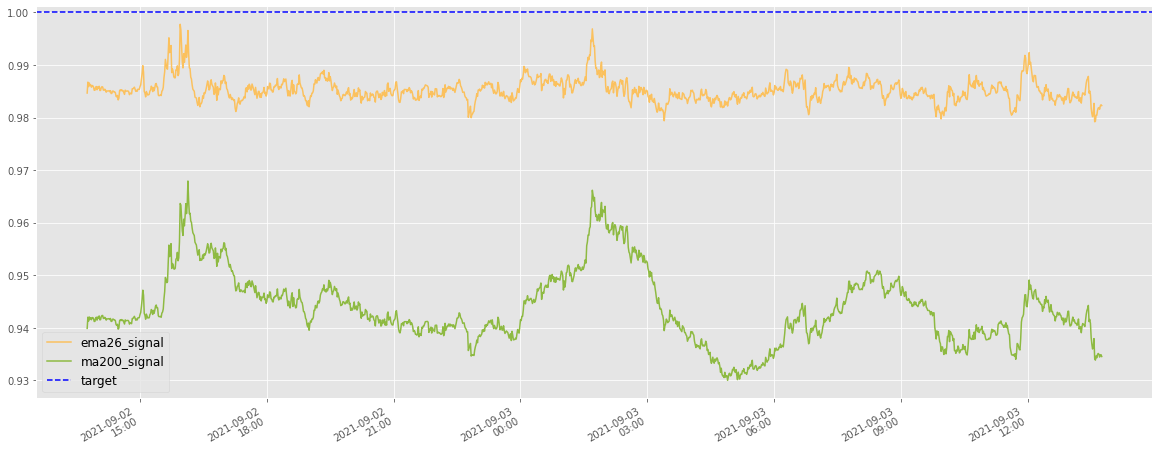

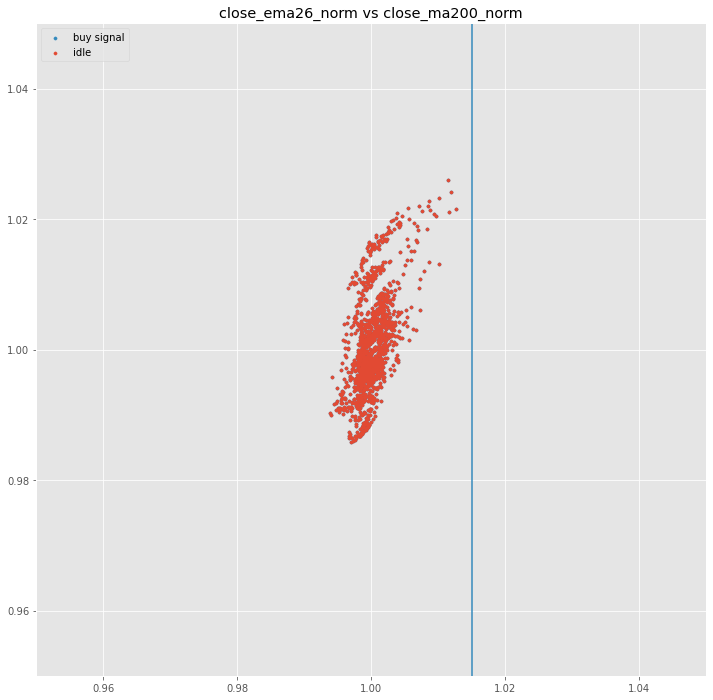

In [347]:
df = download_history_fast(SYMBOL, (
    datetime.now() - timedelta(minutes=1*60*24+200)).strftime('%Y%m%d%H%M%S'), freq=FREQ, days=1.5)

thr_x, thr_y = 1.015, 1.06

df_n = normalise(df)
df_n = df_n[['close', 'close_ema26_norm', 'close_ma200_norm']].dropna()
df_n['ema26_signal'] = df_n['close_ema26_norm'] / thr_x
df_n['ma200_signal'] = df_n['close_ma200_norm'] / thr_y
df_n['buy_signal'] = (df_n['ema26_signal'] >= 1.0) | (df_n['ma200_signal'] >= 1.0)
hyplot(plt.plot, df_n, ['close'])
plt.scatter(df_n[df_n['buy_signal']].index, df_n[df_n['buy_signal']]['close'], c='b', marker='^', s=120, label='buy')
plt.show()
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
hyplot(plt.plot, df_n, ['ema26_signal', 'ma200_signal'], colours=[palette[4], palette[5]], baseline=[1.0], baseline_names=['target'])
print("Past BUY signals")
display_whole(df_n[df_n['buy_signal']].style.format({
    'ema26_signal': '{:.1%}'.format,
    'ma200_signal': '{:.1%}'.format,
}))
print("Latest 10 datapoints")
display_whole(df_n[-10:].style.format({
    'ema26_signal': '{:.1%}'.format,
    'ma200_signal': '{:.1%}'.format,
}))

if df_n.iloc[-1]['buy_signal']:
    print("Suggestion: BUY")
else:
    print("Suggestion: IDLE")
    
plt.figure(figsize=(12, 12))

delta = 0.001
xy_min, xy_max = 0.9, 1.1
xrange = np.arange(xy_min, xy_max, delta)
yrange = np.arange(xy_min, xy_max, delta)
X, Y = np.meshgrid(xrange,yrange)
plt.plot(xrange, [thr_y] * len(xrange), c=palette[1])
plt.plot([thr_x] * len(yrange), yrange, c=palette[1])

to_col = {True: (palette[1], 'buy signal'), False: (palette[0], 'idle')}

for cl, (col, lab) in to_col.items():
    plt.scatter(df_n[df_n['buy_signal'] == c]['close_ema26_norm'], 
                df_n[df_n['buy_signal'] == c]['close_ma200_norm'], 
                s=10, c=col, label=lab)
plt.legend(loc="upper left")
plt.title("close_ema26_norm vs close_ma200_norm")

xy_min, xy_max = 0.95, 1.05
plt.gca().set_xlim([xy_min, xy_max])
plt.gca().set_ylim([xy_min, xy_max])
plt.show()

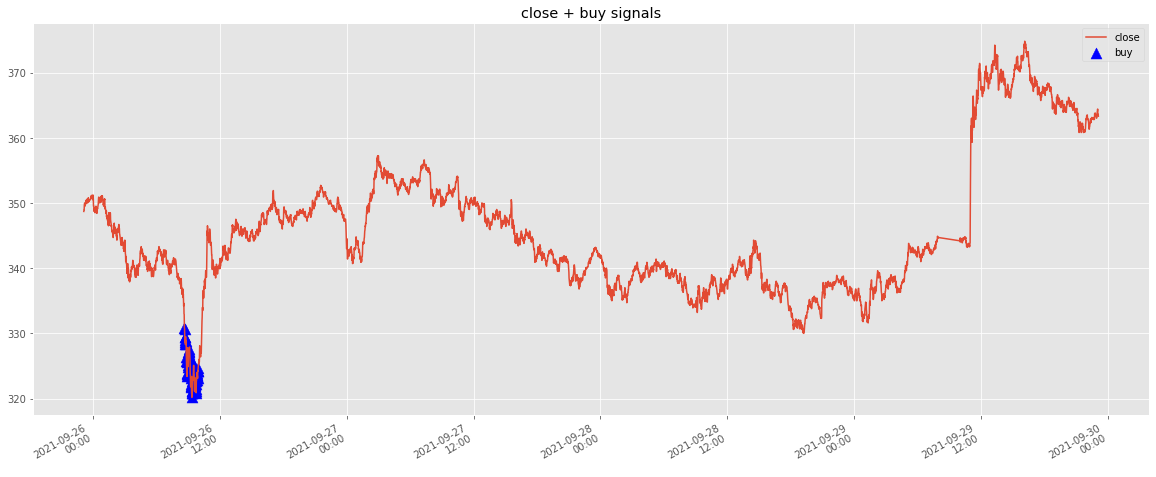

Past BUY signals


,close,close_ema26_norm,close_ma200_norm,buy_signal
2021-09-26 08:38:00,330.900000,1.014690,1.027851,True
2021-09-26 08:39:00,330.700000,1.014170,1.028316,True
2021-09-26 08:40:00,329.500000,1.016541,1.031900,True
2021-09-26 08:41:00,328.700000,1.017606,1.034246,True
2021-09-26 08:42:00,329.400000,1.014300,1.031881,True
2021-09-26 08:43:00,329.000000,1.014382,1.032957,True
2021-09-26 08:44:00,328.300000,1.015320,1.034976,True
2021-09-26 08:46:00,328.300000,1.013385,1.034634,True
2021-09-26 08:47:00,328.500000,1.011822,1.033826,True
2021-09-26 08:48:00,328.800000,1.010092,1.032717,True


Latest 10 datapoints


,close,close_ema26_norm,close_ma200_norm,buy_signal
2021-09-29 22:58:00,363.500000,0.999104,0.999774,False
2021-09-29 22:59:00,363.600000,0.998916,0.999477,False
2021-09-29 23:00:00,363.600000,0.998996,0.999457,False
2021-09-29 23:01:00,364.000000,0.998054,0.998343,False
2021-09-29 23:02:00,364.100000,0.997944,0.998047,False
2021-09-29 23:03:00,364.400000,0.997336,0.997208,False
2021-09-29 23:04:00,363.600000,0.999565,0.999378,False
2021-09-29 23:05:00,363.500000,0.999852,0.999635,False
2021-09-29 23:06:00,363.600000,0.999608,0.999348,False
2021-09-29 23:07:00,363.300000,1.000401,1.000164,False


Suggestion: IDLE


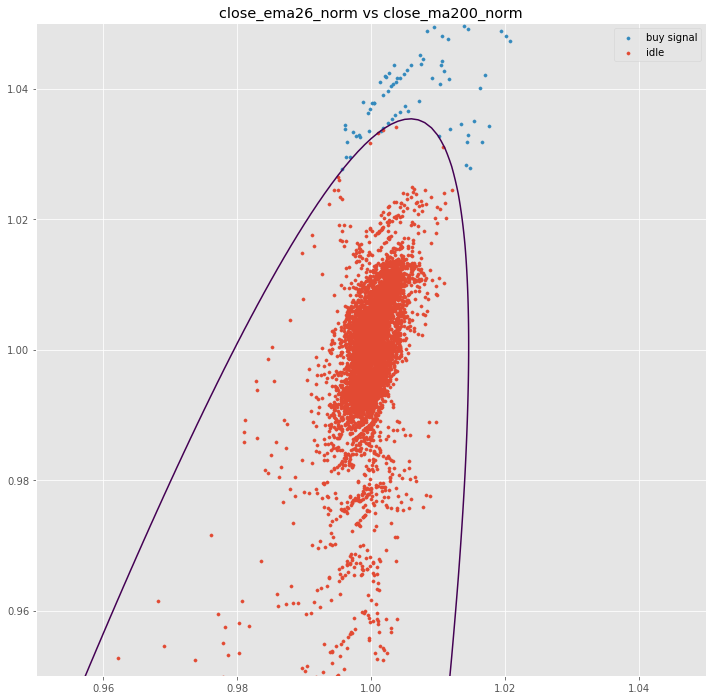

In [103]:
def is_good_signal(X, Y, decfun=False):
    Tx = -0.809
    Ty = -0.234
    F = (12*(X+Tx) - 3*(Y+Ty))**2 + (X+Tx) + (Y+Ty) - 1
    return F if decfun else F >= 0

DAYS = 4

df = download_history_fast(SYMBOL, (
    datetime.now() - timedelta(minutes=DAYS*60*24+200)).strftime('%Y%m%d%H%M%S'), freq=FREQ, days=DAYS+0.5)

df_n = normalise(df)
df_n = df_n[['close', 'close_ema26_norm', 'close_ma200_norm']].dropna()
df_n['buy_signal'] = np.vectorize(is_good_signal)(df_n['close_ema26_norm'], df_n['close_ma200_norm'])
hyplot(plt.plot, df_n, ['close'])
plt.scatter(df_n[df_n['buy_signal']].index, df_n[df_n['buy_signal']]['close'], c='b', marker='^', s=120, label='buy')
plt.legend(loc="best")
plt.title("close + buy signals")
plt.show()
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
# plot(plt.plot, df_n, ['ema26_signal', 'ma200_signal'], colours=[palette[4], palette[5]], baseline=[1.0], baseline_names=['target'])
print("Past BUY signals")
display_whole(df_n[df_n['buy_signal']].style.format({
    'ema26_signal': '{:.1%}'.format,
    'ma200_signal': '{:.1%}'.format,
}))
print("Latest 10 datapoints")
display_whole(df_n[-10:].style.format({
    'ema26_signal': '{:.1%}'.format,
    'ma200_signal': '{:.1%}'.format,
}))

if df_n.iloc[-1]['buy_signal']:
    print("Suggestion: BUY")
else:
    print("Suggestion: IDLE")
    
plt.figure(figsize=(12, 12))

to_col = {1: 'buy signal', 0: 'idle'}

delta = 0.001
xy_min, xy_max = 0.9, 1.1
xrange = np.arange(xy_min, xy_max, delta)
yrange = np.arange(xy_min, xy_max, delta)
X, Y = np.meshgrid(xrange,yrange)
F = is_good_signal(X, Y, decfun=True)
plt.contour(X, Y, F, [0])

for c, cl in to_col.items():
    plt.scatter(df_n[df_n['buy_signal'] == c]['close_ema26_norm'], 
                df_n[df_n['buy_signal'] == c]['close_ma200_norm'], 
                s=10, c=palette[c], label=cl)
plt.legend(loc="best")
plt.title("close_ema26_norm vs close_ma200_norm")

xy_min, xy_max = 0.95, 1.05
plt.gca().set_xlim([xy_min, xy_max])
plt.gca().set_ylim([xy_min, xy_max])
plt.show()

In [4]:
df_n.sort_values(by=['close_ema26_norm'], ascending=False).iloc[:20]

,close,close_ema26_norm,close_ma200_norm,buy_signal
2021-09-13 15:19:00,386.1,1.028775,1.032143,True
2021-09-13 15:03:00,393.1,1.028331,1.013698,True
2021-09-13 15:20:00,388.0,1.021979,1.027001,True
2021-09-13 15:22:00,387.0,1.021391,1.029468,True
2021-09-13 15:21:00,388.6,1.018890,1.025333,True
2021-09-10 15:32:00,396.6,1.017808,1.037117,True
2021-09-13 15:04:00,397.0,1.016879,1.003771,True
2021-09-13 15:05:00,396.5,1.016816,1.005063,True
2021-09-13 15:12:00,393.9,1.016231,1.011882,True
2021-09-10 15:30:00,398.3,1.016094,1.033116,True


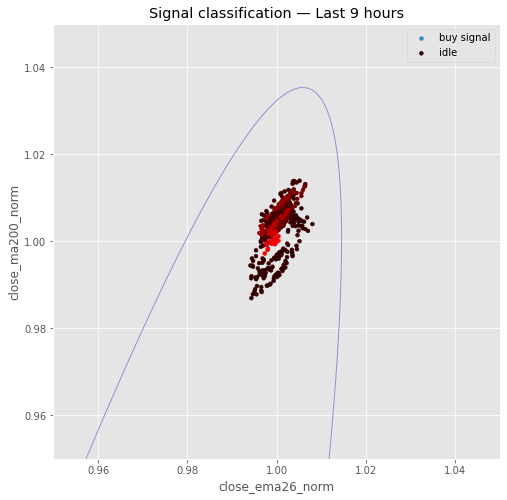

In [153]:
plt.figure(figsize=(8, 8))

delta = 0.001
xy_min, xy_max = 0.9, 1.1
xrange = np.arange(xy_min, xy_max, delta)
yrange = np.arange(xy_min, xy_max, delta)
X, Y = np.meshgrid(xrange,yrange)
F = is_good_signal(X, Y, decfun=True)
plt.contour(X, Y, F, [0], colors=palette[2], linewidths=1)

n_hours = 9
n_datapoints = n_hours * 60
df_asd = df_n.copy().iloc[-n_datapoints:]
# n_datapoints = len(df_asd)
df_asd['buy_signal'] = np.vectorize(is_good_signal)(df_asd['close_ema26_norm'], df_asd['close_ma200_norm'])
colour = []
for i, (index, row) in enumerate(df_asd.iterrows()):
    level = f"{50+int((i/n_datapoints)**(5)*206):02x}"
    if row['buy_signal'] == False:
        colour.append(f'#{level}0000')
    else:
        colour.append(f'#0000{level}')
    if row['buy_signal'] == True:
        label.append('buy signal')
    else:
        label.append('idle')

df_asd['colour'] = colour

# plt.plot(df_asd['close_ema26_norm'], df_asd['close_ma200_norm'], 'gray', linewidth=.2)

for c, cl in to_col.items():
    dfx_asd = df_asd[df_asd['buy_signal'] == c]
    plt.scatter(dfx_asd['close_ema26_norm'], dfx_asd['close_ma200_norm'], s=15, c=dfx_asd['colour'], label=cl)

plt.legend(loc="best")
plt.title(f"Signal classification — Last {n_hours} hours")

xy_min, xy_max = 0.95, 1.05
plt.gca().set_xlim([xy_min, xy_max])
plt.gca().set_ylim([xy_min, xy_max])
plt.xlabel('close_ema26_norm')
plt.ylabel('close_ma200_norm')
plt.show()